# Predicting sentiment from product reviews

Use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

In [9]:
import math
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

sns.set()
%matplotlib inline

In [11]:
products = pd.read_csv('food_products.csv')

,product_id,summary,review,rating
0,4408,Does increase milk supply,This really helped to increase my milk supply....,3.0
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0
...,...,...,...,...
1245,2870,10 times the price,I recently bought Domino 10 lb premium cane su...,1.0
1246,8823,Sweet & Crunchy Peanuts,While these are not the highest quality peanut...,3.0
1247,6343,Annies GF Mac Deluxe,"I had been using Annies GF Mac n Cheese, then ...",4.0
1248,5801,"OK, but Check the Pricing",Dr. Oz recommended this brand of coconut water...,3.0


In [12]:
products = products[products['rating'] != 3]
products = products.copy()  # This is to avoid having a view on the old data

<Axes: title={'center': 'Number of reviews with a given rating'}, xlabel='rating', ylabel='Count'>

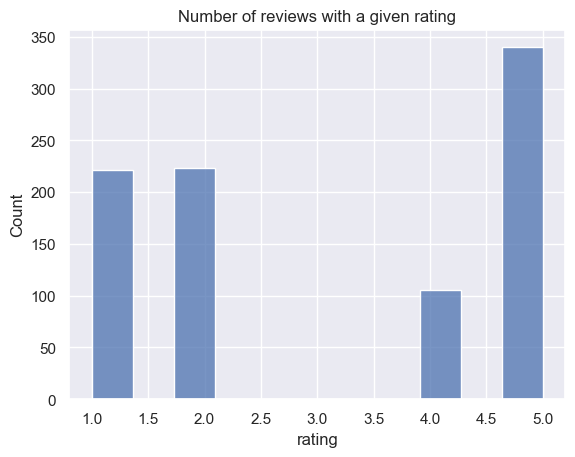

In [13]:
plt.title('Number of reviews with a given rating')
sns.histplot(products['rating'])

In [14]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [15]:
def remove_punctuation(text):
    if type(text) is str:
        return text.translate(str.maketrans('', '', string.punctuation))
    else:
        return ''

products['review_clean'] = products['review'].apply(remove_punctuation)

In [16]:
# Make counts
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(products['review_clean'])

# Make a new DataFrame with the counts information
product_data = pd.DataFrame(count_matrix.toarray(),
        index=products.index,
        columns=vectorizer.get_feature_names_out())

# Add the old columns to our new DataFrame.
product_data['sentiment'] = products['sentiment']
product_data['review_clean'] = products['review_clean']
product_data['summary'] = products['summary']

In [17]:
train_data, test_data = train_test_split(product_data, test_size=0.2, random_state=3)
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=3)

# Majority class classifier

In [18]:
# "Train" a majority class classifier and calculate its validation accuracy

data = pd.DataFrame(count_matrix.toarray(),
       index=products.index,
       columns=vectorizer.get_feature_names_out())

word_count = {}

for col in data:
  count = data[col].sum()
  word_count[col + '_count'] = count

# the most frequent sentiment
positive_count = 0
negative_count = 0

for num in train_data['sentiment']:
  if num == 1:
    positive_count += 1
  else:
    negative_count += 1

if positive_count > negative_count:
  majority_label = 1
else:
  majority_label = -1

majority_classifier_validation_accuracy = (validation_data['sentiment'] == majority_label).sum() / len(validation_data)

# Train a sentiment classifier with logistic regression

In [21]:
features = vectorizer.get_feature_names_out()

sentiment_model = LogisticRegression(penalty='l2', random_state=1, C=1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])
coefficients = sentiment_model.coef_[0]

# Most Positive/Negative Word

In [22]:
# Find the most positive word and most negative word in the sentiment_model

most_negative_word = features[np.argmin(coefficients)]
most_positive_word = features[np.argmax(coefficients)]

# Most Positive/Negative Review

In [23]:
positive_idx = np.argmax(sentiment_model.predict_proba(validation_data[features])[:, 1])

most_positive_review = product_data.loc[validation_data.index[positive_idx], 'review_clean']
most_negative_review = product_data.iloc[np.argmin(sentiment_model.predict_proba(validation_data[features])[:, -1])]['review_clean']

# Compute validation accuracy

In [24]:
from sklearn.metrics import accuracy_score

pred_sentiment = sentiment_model.predict(validation_data[features])

sentiment_model_validation_accuracy = accuracy_score(validation_data['sentiment'], pred_sentiment)

# Create a confusion matrix

In [25]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

# Compute confusion matrix values and plot

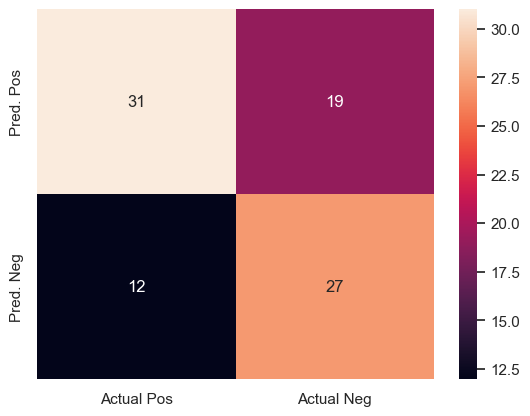

In [26]:
tp = np.sum((validation_data['sentiment'] == 1) & (pred_sentiment == 1))
fp = np.sum((validation_data['sentiment'] == -1) & (pred_sentiment == 1))
fn = np.sum((validation_data['sentiment'] == 1) & (pred_sentiment == -1))
tn = np.sum((validation_data['sentiment'] == -1) & (pred_sentiment == -1))

plot_confusion_matrix(tp, fp, fn, tn)

# Logistic Regression with L2 regularization

In [28]:
# Set up the regularization penalities to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]'
                    for l2_penalty in l2_penalties]

# Add the coefficients to this coef_table for each model
coef_table = pd.DataFrame(columns=['word'] + l2_penalty_names)
coef_table['word'] = features

# Set up an empty list to store the accuracies (will convert to DataFrame after loop)
accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
    # Train the model
    model = LogisticRegression(penalty = 'l2', random_state = 1, C = (1/l2_penalty), fit_intercept = False)
    model.fit(train_data[features], train_data['sentiment'])
    # Save the coefficients in coef_table
    coef_table[l2_penalty_column_name] = model.coef_[0]
    # Calculate and save the train and validation accuracies
    accuracy_data.append({
        'l2_penalty': l2_penalty,
        'train_accuracy': model.score(train_data[features], train_data['sentiment']),
        'validation_accuracy': model.score(validation_data[features], validation_data['sentiment'])
    })

accuracies_table = pd.DataFrame(accuracy_data)

# Inspect Coefficients

In [29]:
positive_words = coef_table.nlargest(5, 'coefficients [L2=1e+00]')['word']

negative_words = coef_table.nsmallest(5, 'coefficients [L2=1e+00]')['word']